# Solve the Transverse-Field Ising Model using Fire Opal
**Using Fire Opal's `estimate_expectation` to solve TFIM** 

The Transverse-field Ising Model (TFIM) is widely used to study quantum spin systems and phase transitions. It describes a lattice of quantum spins with nearest-neighbor interactions and an external magnetic field applied perpendicular to the spin alignment axis. Simulating the Transverse-field Ising Model is a challenging task due to noise and decoherence. Fire Opal's `estimate_expectation` function provides an optimized calculation of single-qubit magnetizations, enhancing the solution of the TFIM on real hardware devices.

This application note provides a practical example of TFIM implementation, covering the following:

* Implementing the TFIM Hamiltonian on a graph of connected spin triangles
* Simulating time evolution using Trotterized circuits under varying depths
* Estimating and visualizing single-qubit magnetizations $\langle 𝑍_𝑖 \rangle$ over time
* Comparing results with and without Fire Opal’s

Ultimately, this example highlights Fire Opal’s ability to improve signal fidelity in quantum many-body simulations.

## 1. Introduction

The Transverse-field Ising Model (TFIM) is a quantum spin model that captures essential features of quantum phase transitions. The Hamiltonian is defined as:

$$
H = -J \sum_{i} Z_i Z_{i+1} - h \sum_{i} X_i
$$

where $Z_i$ and $X_i$ are Pauli operators acting on qubit $i$, $J$ is the coupling strength between neighboring spins, and $h$ is the strength of the transverse magnetic field. The first term represents classical ferromagnetic interactions, while the second introduces quantum fluctuations through the transverse field. To simulate TFIM dynamics, you use a **Trotter decomposition** of the unitary evolution operator $e^{-iHt}$, implemented through layers of RX and RZZ gates based on a custom graph of connected spin triangles. The simulation explores how magnetization $\langle Z \rangle$ evolves with increasing Trotter steps.

TFIM implementation performance is obtained by comparing **noiseless simulations** with **noisy backends**. Fire Opal’s enhanced execution and error suppression features are used to mitigate the effect of noise in real hardware, yielding more reliable estimates of spin observables like $\langle Z_i \rangle$ and correlators $\langle Z_i Z_j \rangle$.




## 2. Imports and initialization
You can find detailed guidelines for [setting up your development environment](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-set-up-your-environment-and-install-fire-opal).

In [1]:
import numpy as np
import networkx as nx
import fireopal as fo
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import qasm3
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

To use Fire Opal within your local development environment or the Braket console you should [authenticate using an API key](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-authenticate-using-an-api-key).


In [ ]:
api_key = "YOUR_QCTRL_API_KEY"
fo.authenticate_qctrl_account(api_key=api_key)

# Set credentials.
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"

credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

Q-CTRL authentication successful!


## 3. Set up the problem

### 3.1. Generate the TFIM Graph

First you need to create the lattice of quantum spins, defining the spin-spin coupling. In this particular case, you will generate an adjacency matrix for a graph composed of $n$ connected triangles arranged as a linear chain. Each triangle is formed by three fully connected nodes, creating a closed loop. The function `connected_triangles_adj_matix` generates this graph, linking the first node of each new triangle with the last node of the previous one leading to a total of $2n+1$ nodes.  

In [3]:
def connected_triangles_adj_matrix(n):
    """
    Generate the adjacency matrix for 'n' connected triangles in a chain.
    """
    num_nodes = 2 * n + 1
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(n):
        a, b, c = i * 2, i * 2 + 1, i * 2 + 2  # Nodes of the current triangle

        # Connect the three nodes in a triangle
        adj_matrix[a, b] = adj_matrix[b, a] = 1
        adj_matrix[b, c] = adj_matrix[c, b] = 1
        adj_matrix[a, c] = adj_matrix[c, a] = 1

        # If not the first triangle, connect to the previous triangle
        if i > 0:
            adj_matrix[a, a - 1] = adj_matrix[a - 1, a] = 1

    return adj_matrix

### 3.2 Color Graph Edges

Given a graph representing the spin interaction lattice, the function `edge_coloring` provides a way to identify sets of non-overlapping edges. It converts the graph to a line graph, where each node corresponds to an edge in the original graph. It then performs a [coloring](https://en.wikipedia.org/wiki/Graph_coloring) of the line graph so that adjacent edges are assigned different colors.

In [6]:
def edge_coloring(graph):
    """
    Takes a NetworkX graph and returns a list of lists where each inner list contains
    the edges assigned the same color.
    """
    line_graph = nx.line_graph(graph)
    edge_colors = nx.coloring.greedy_color(line_graph)

    color_groups = {}
    for edge, color in edge_colors.items():
        if color not in color_groups:
            color_groups[color] = []
        color_groups[color].append(edge)

    return list(color_groups.values())

### 3.3 Generate Trotterized Circuits on Spin Graphs

To simulate quantum dynamics governed by the Transverse-field Ising Model (TFIM), the function `generate_tfim_circ_custom_graph` constructs a Trotterized quantum circuit from an arbitrary spin interaction graph. It implements the time evolution operator:

$$
e^{-i H t}, \quad \text{with} \quad H = -J \sum_{\langle i,j \rangle} Z_i Z_j - h \sum_i X_i,
$$

using second-order Trotter decomposition. The evolution is split into alternating layers of local rotations using `RX` gates for the transverse field and entangling interactions using `RZZ` gates for spin-spin couplings. The gate angles are determined by the simulation time step `dt`, the transverse field strength `h`, and the coupling constant `J`. The produced circuit simulates TFIM dynamics across various depths and configurations and is used repeatedly across different Trotter step counts to analyze magnetization evolution.


In [ ]:
def generate_tfim_circ_custom_graph(
    steps, h, J, dt, psi0, graph: nx.graph.Graph, meas_basis="Z", mirror=False
):
    """
    Generate a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2) for simulating a transverse field ising model:
    e^{-i H t} where the Hamiltonian H = -J \\sum_i Z_i Z_{i+1} + h \\sum_i X_i.

    steps: Number of trotter steps
    theta_x: Angle for layer of X rotations
    theta_zz: Angle for layer of ZZ rotations
    theta_x: Angle for second layer of X rotations
    J: Coupling between nearest neighbouring spins
    h: The transverse magnetic field strength
    dt: t/total_steps
    psi0: initial state (assumed to be prepared in the computational basis).
    meas_basis: basis to meaasure all correlators in

    This is a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2)
    """
    theta_x = h * dt
    theta_zz = -2 * J * dt
    nq = graph.number_of_nodes()
    color_edges = edge_coloring(graph)
    circ = QuantumCircuit(nq, nq)
    # Initial state, for typical cases in the computational basis
    for i, b in enumerate(psi0):
        if b == "1":
            circ.x(i)
    # Trotter steps
    for step in range(steps):
        for i in range(nq):
            circ.rx(theta_x, i)
        if mirror:
            color_edges = [sublist[::-1] for sublist in color_edges[::-1]]
        for edge_list in color_edges:
            for edge in edge_list:
                circ.rzz(theta_zz, edge[0], edge[1])
        for i in range(nq):
            circ.rx(theta_x, i)

    # some typically used basis rotations
    if meas_basis == "X":
        for b in range(nq):
            circ.h(b)
    elif meas_basis == "Y":
        for b in range(nq):
            circ.sdg(b)
            circ.h(b)

    for i in range(nq):
        circ.measure(i, i)

    return circ


def trotter_circuits(G, d_ind_tot, J, h, dt, meas_basis, mirror=True):
    """
    Generates a sequence of Trotterized circuits, each with increasing depth.
    Given a spin interaction graph and Hamiltonian parameters, it constructs
    a list of circuits with 1 to d_ind_tot Trotter steps

    G: Graph defining spin interactions (edges = ZZ couplings)
    d_ind_tot: Number of Trotter steps (maximum depth)
    J: Coupling between nearest neighboring spins
    h: Transverse magnetic field strength
    dt: (t / total_steps
    meas_basis: Basis to measure all correlators in
    mirror: If True, mirror the Trotter layers
    """
    qubit_count = len(G)
    circuits = []
    psi0 = "0" * qubit_count

    for steps in range(1, d_ind_tot + 1):
        circuits.append(
            generate_tfim_circ_custom_graph(
                steps, h, J, dt, psi0, G, meas_basis, mirror
            )
        )
    return circuits

### 3.2 Estimate Single-Qubit Magnetizations ⟨Zᵢ⟩

To analyze the magnetization dynamics of the Transverse-field Ising Model, you need to compute the expectation value of the Pauli-Z operator on each individual qubit. For the exact simulation you will use the function `z_expectation` to compute the magnetization $\langle Z_i \rangle$ from bitstring measurement results.  For real devices, Fire Opal's `estimate_expectation` function evaluates the magnetization expectation values from a dictionary defining the specific qubit $i$. These methods are necessary for assessing local magnetization and tracking the time evolution of spin observables in quantum circuits.


In [ ]:
def z_expectation(counts, index):
    """
    counts: Dict of mitigated bitstrings.
    index: Index i in the single operator expectation value < II...Z_i...I > to be calculated.
    return:  < Z_i >
    """
    z_exp = 0
    tot = 0
    for bitstring, value in counts.items():
        sum = int(bitstring[index])
        sign = 1
        if sum % 2 == 1:
            sign = -1
        z_exp += sign * value
        tot += value

    return z_exp / tot

In [ ]:
def generate_z_observables(nq):
    observables = []
    for i in range(nq):
        pauli_string = "".join(["Z" if j == i else "I" for j in range(nq)])
        observables.append((pauli_string, 1))
    return observables

## 4. Run the algorithm

### 4.1 Selecting the quantum device

[Choose a backend](https://docs.q-ctrl.com/fire-opal/discover/start-using/get-started-with-fire-opal-on-ibm-quantum) from the supported devices your IBM account has access to, and replace `desired_backend` with the target name. In this application note you will use the `statevector` simulator to as baseline, this will not be suitable for circuits with large number of qubits. 

In [9]:
fo.show_supported_devices(credentials=credentials)

{'supported_devices': ['ibm_sherbrooke',
  'ibm_kingston',
  'ibm_brisbane',
  'test_eagle_us-east',
  'ibm_fez',
  'ibm_strasbourg',
  'ibm_marrakesh',
  'test_eagle_eu-de',
  'ibm_aachen',
  'ibm_torino',
  'ibm_brussels']}

In [ ]:
backend_name = "desired_backend"
backend_sim = AerSimulator(method="statevector")

### 4.2 Build and running the Trotterized circuits

You need to define the parameters for generating the Trotterized circuits that simulate the Transverse-field Ising Model (TFIM) on the graph of connected spin triangles. In this case, the lattice is composed of a chain of 12 triangles arranged linearly producing a 25-qubit system.

In [ ]:
all_circs_mirror = []
for num_triangles in [12]:
    for meas_basis in ["Z"]:
        A = connected_triangles_adj_matrix(num_triangles)
        G = nx.from_numpy_array(A)
        nq = len(G)
        d_ind_tot = 21
        dt = 2 * np.pi * 1 / 30 * 0.5
        J = 1
        h = -4
        all_circs_mirror.extend(
            trotter_circuits(G, d_ind_tot, J, h, dt, meas_basis, True)
        )
circs = all_circs_mirror

### 4.3 Calculate Magnetization Dynamics
#### 4.3.1 Exact Simulations
To calculate observables from exact simulations, the circuit list `circ_list` is executed on the `statevector` simulator using `run_sim`, which runs each circuit with $4096$ shots and normalizes the raw bitstring counts via `normalize_counts`. These normalized results are then passed to `make_coorelators`, which computes single-qubit Z expectation values ⟨Zᵢ⟩ at each Trotter step (`d_ind_tot`). Finally, `make_cors` averages these Z values over all qubits, returning a 1D array `sim_exp` that summarizes the magnetization dynamics over time.


In [23]:
def normalize_counts(counts_list, shots):
    new_counts_list = []
    for counts in counts_list:
        a = {k: v / shots for k, v in counts.items()}
        new_counts_list.append(a)
    return new_counts_list

In [26]:
def run_sim(circ_list):
    shots = 4096
    res = backend_sim.run(circ_list, shots=shots)
    normed = normalize_counts(res.result().get_counts(), shots)
    return normed

In [27]:
sim_counts = run_sim(circs)

In [ ]:
def make_coorelators(test_counts, nq, d_ind_tot):
    """
    d_ind_tot : max_depth
    """
    mz = np.empty((nq, d_ind_tot))  # <Z_i>

    for d_ind in range(d_ind_tot):
        counts = test_counts[d_ind]
        for i in range(nq):
            mz[i, d_ind] = z_expectation(counts, i)
    return mz


def make_cors(counts, nq):
    d_ind_tot = 21
    mz = make_coorelators(counts, nq, d_ind_tot=d_ind_tot)
    average_z = np.mean(mz, axis=0)
    return np.concatenate((np.array([1]), average_z), axis=0)

In [44]:
sim_exp = make_cors(sim_counts[0:21], nq=21)

#### 4.3.2 Real Devices
To evaluate magnetization dynamics on real quantum hardware, the circuits are executed on the selected IBM backend using Fire Opal’s `estimate_expectation` function. The Trotter-evolved circuits are divided into two batches to meet hardware submission limits. Each batch is submitted with $4096$ shots, and Pauli-Z observables are measured across all qubits using the dictionary generated by `generate_z_observables`. The resulting expectation values are concatenated and grouped by Trotter step. The average over qubits for each step is calculated, obtaining the observed magnetization evolution from real-device execution.


In [24]:
fire_opal_job_A = fo.estimate_expectation(
    circuits=[qasm3.dumps(qc) for qc in all_circs_mirror[:11]],
    shot_count=4096,
    credentials=credentials,
    backend_name=backend_name,
    observables=generate_z_observables(nq),
)
fire_opal_job_B = fo.estimate_expectation(
    circuits=[qasm3.dumps(qc) for qc in all_circs_mirror[11:]],
    shot_count=4096,
    credentials=credentials,
    backend_name=backend_name,
    observables=generate_z_observables(nq),
)

In [74]:
JOB = (
    fire_opal_job_A.result()["expectation_values"]
    + fire_opal_job_B.result()["expectation_values"]
)
JOB_Hlist = [JOB[i : i + 25] for i in range(0, len(JOB), 25)]
real_exp = np.concatenate((np.array([1]), np.mean(JOB_Hlist, axis=1)), axis=0)

## 5. Results
You can compare the magnetization $\langle Z \rangle$ obtained from real hardware execution against the exact simulation baseline across Trotter steps. This visualization provides a clear view of how closely the Fire Opal's `estimate_expectation` aligns with the exact solution for the quantum evolution.


In [ ]:
def make_expectations_plot(exp_z, exp_z_error, sim_z, depths, name):

    plot_upto = 21
    plot_from = 0
    depth_ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    top = np.max(sim_z[plot_from:plot_upto])
    bottom = np.min(sim_z[plot_from:plot_upto])
    top = 1.05
    bottom = -1.05

    ax.plot(
        depths[plot_from:plot_upto],
        sim_z[plot_from:plot_upto],
        color="grey",
        label="Noiseless simulation",
    )

    if name == "qctrl":
        ax.errorbar(
            depths[plot_from:plot_upto],
            exp_z[plot_from:plot_upto],
            yerr=exp_z_error[plot_from:plot_upto],
            fmt="o",
            markersize=7,
            color="#680CE9",
            label="Fire Opal",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )
    elif name == "estimator":
        ax.errorbar(
            depths[plot_from:plot_upto],
            exp_z[plot_from:plot_upto],
            yerr=exp_z_error[plot_from:plot_upto],
            fmt="o",
            markersize=7,
            color="black",
            label="Default QiskitRuntime",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )

    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xticks(depth_ticks)
    ax.set_xlabel("Trotter step")
    ax.legend()
    ax.set_ylim(bottom, top)
    ax.legend(prop={"size": 8})
    plt.tight_layout()
    plt.show()

In [72]:
depths = list(range(d_ind_tot + 1))
errors = np.abs(np.array(real_exp) - np.array(sim_exp))

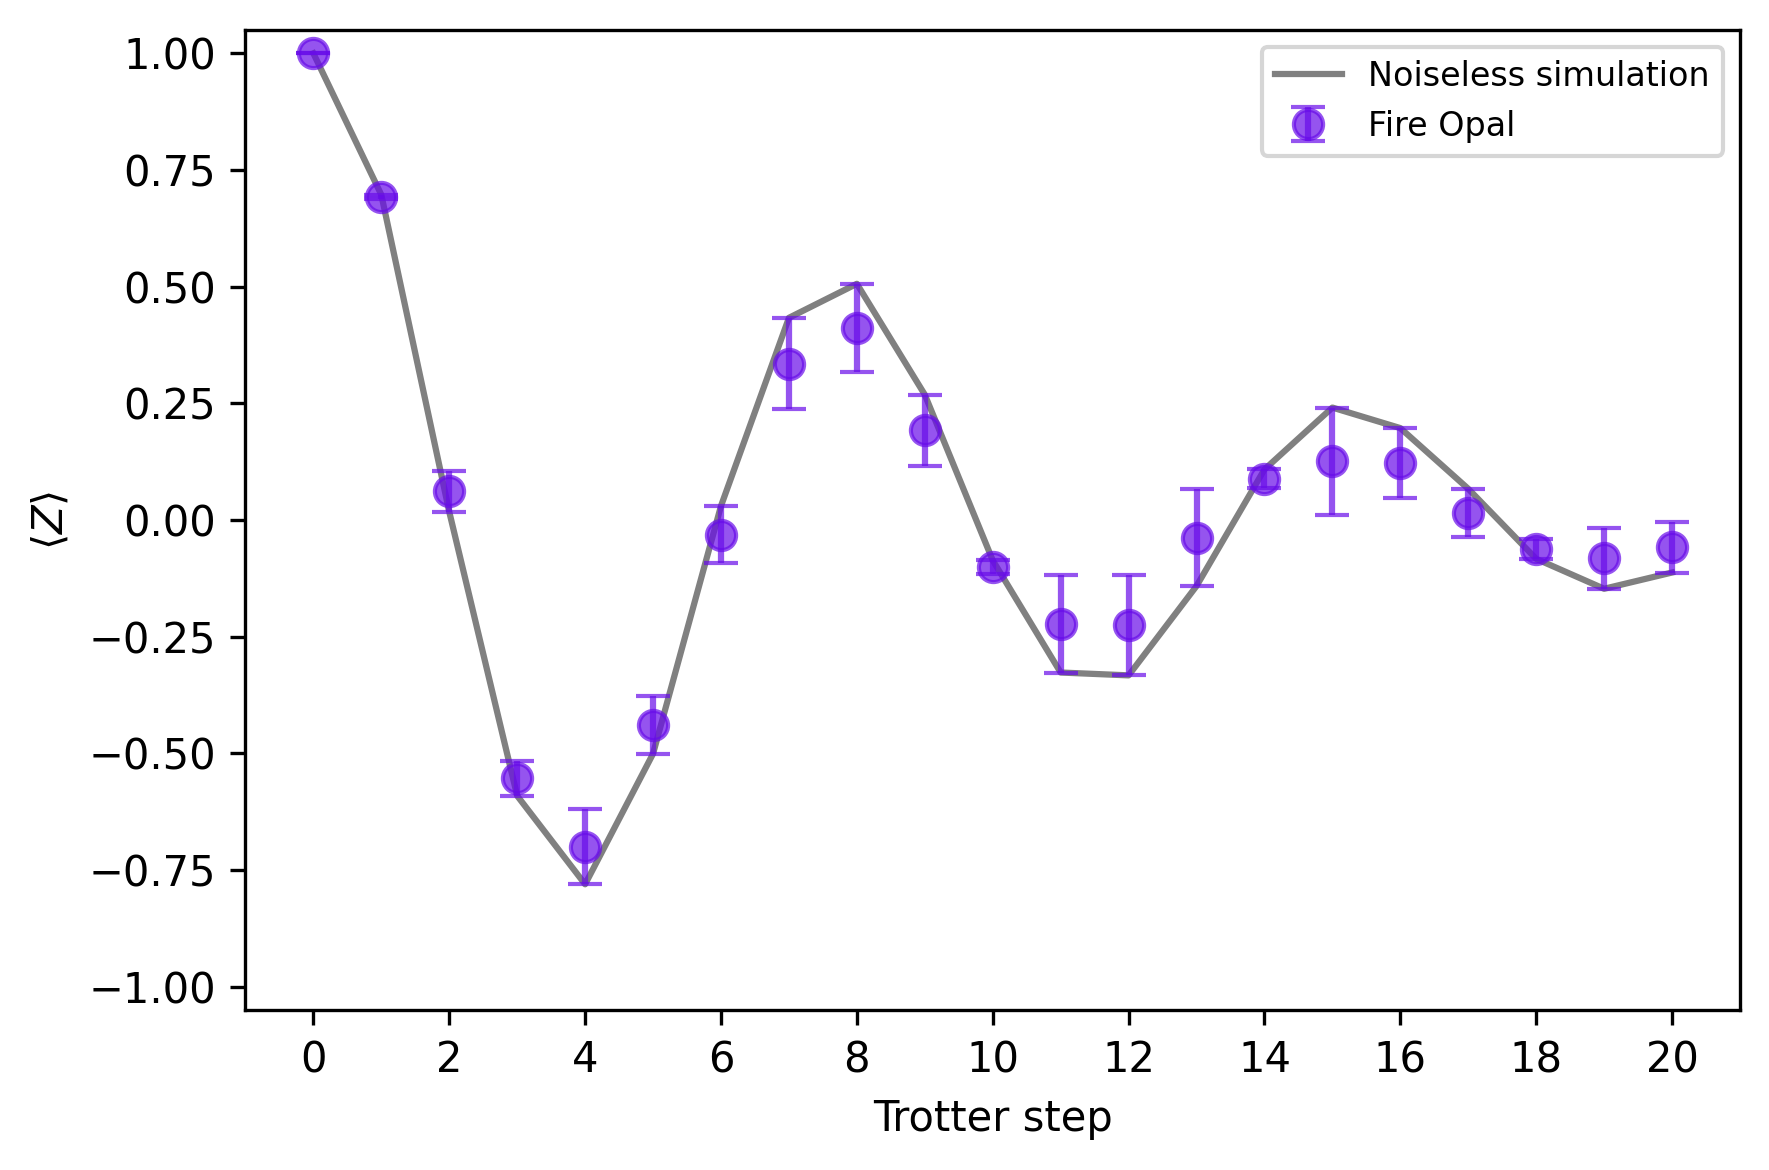

In [75]:
make_expectations_plot(real_exp, errors, sim_exp, depths, "qctrl")

This analysis demonstrates how Fire Opal can be used to calculate the Transverse-field Ising Model. The agreement between simulated and measured results highlights the potential of Fire Opal for capturing key physical behaviors.


In [76]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.9  |
| matplotlib            | 3.10.1  |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| qiskit                | 1.4.2   |
| qiskit-ibm-runtime    | 0.36.1  |
| sympy                 | 1.13.3  |
| fire-opal             | 8.4.1   |
| qctrl-workflow-client | 5.5.0   |
